In [215]:
import numpy as np
import matplotlib.pyplot as plt

In [216]:
def z_to_t(z):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    return (2/(3*np.sqrt(Omega_L)) * 1/(h*100*1e5/(R*1e6))
           *np.arcsinh(np.sqrt(Omega_L/(Omega_M*(1 + z)**3)))*3.17*1e-14)

In [217]:
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]
M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e6*M_sun
R = 3.0856776*1e18 # [cm] 1pc
kB = 1.38*1e-16 # [эрг * К^-1]
c = 3.*1e10 # [sm/s]
h = 0.674
m_p = 1.67e-24 # Масса протона [g]

T_0 = 2.726 # [K] современная температура фотонов
a1 = 1/119
a2 = 1/115

Сетка

In [218]:
r_min = 1e19    # [cm]
r_max = 1e21    # [cm]
length = 100
r = np.linspace(r_min,r_max,length)
dr = r[1] - r[0]

T_s_Myr = 3.17*1e-14 #перевод секунд в Myr

rho = np.zeros((2,length))
U = np.zeros((2,length))
dPhi_dr = np.zeros((2,length))
rhoU = np.zeros((2,length))
T = np.zeros((2,length))
e = np.zeros((2,length))
P = np.zeros((2,length))

In [219]:
S = np.zeros(length)
V = np.zeros(length-1)

U_half = np.zeros(length)

Обьемы и площади

In [220]:
rh = np.append(r[0]-dr/2,(np.append(r,r[-1]+dr)[1:] + r)/2)  #границы ячеек

S = 4*np.pi*rh**2
V = 4/3*np.pi*(rh[1:]**3 - rh[:-1]**3)

Начальные условия

In [221]:
z_in = 100
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)

rho[0,:] = H**2/(8/3*np.pi*G)
U[0,:] = H*r[:]
rhoU[0,:] = rho[0,:]*U[0,:]
Uh = H*rh
T[0,:] = T_0 * (1+z_in) * (1 + a1**(-1)*(1+z_in)**(-1)/(1+a2**(3/2)*(1+z_in)**(3/2)))**(-1)
P[0,:] = rho[0,:]*kB*T[0,:]/m_p
e[0,:] = 3/2*P[0,:]/rho[0,:]

dPhi_dr[0,:] = G*rho[0,:]*4/3*np.pi*rh[:-1] + G*M_pbh/rh[:-1]**2

t = t_in
t_vector = t_in
dt = t_in/100
sim_time = 0

i = 0

In [222]:
# # Условие КФЛ
# a = np.sqrt((P[0,1:]-P[0,:-1])/(rho[0,1:]-rho[0,:-1])) # скорость звука в газе

In [223]:
S.shape

(101,)

Решение

In [224]:
while t<t_in*6:
    # 1 и 3 слагаемые вычитают, а 2 и 4 добавляют
    rho[i+1,1:-1] = (rho[i,1:-1]
                    - dt*rho[i,1:-1]*Uh[2:-1]*S[2:-1]/V[1:-1]*np.where(Uh[2:-1]>0, 1, 0)
                    + dt*rho[i,1:-1]*Uh[1:-2]*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]<0, 1, 0)
                    + dt*rho[i,:-2]*Uh[1:-2]*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]>0, 1, 0)
                    - dt*rho[i,2:]*Uh[3:]*S[3:]/V[1:-1]*np.where(Uh[3:]<0, 1, 0))

    rho[i+1,0] = (rho[i,0]
                  + dt*rho[i,0]*Uh[0]*S[0]/V[0]*(Uh[0]<0)
                  - dt*rho[i,0]*Uh[1]*S[1]/V[0]*(Uh[1]<0))
    rho[i+1,-1] = (rho[i,-1]
                  - dt*rho[i,-1]*Uh[-1]*S[-1]/V[-1]*(Uh[-1]>0)
                  + dt*rho[i,-1]*Uh[-2]*S[-2]/V[-1]*(Uh[-2]>0))

    if Uh[0]>0:
        rho[i+1,0] = rho[i+1,1]
    elif Uh[-1]<0:
        rho[i+1,-1] = rho[i+1,-2]

    # первые 4 слагаемых идентичны rho а следующие два отвечают за давление и гравитацию
    rhoU[i+1,1:-1] = (rhoU[i,1:-1]
                    - dt*rho[i,1:-1]*Uh[2:-1]**2*S[2:-1]/V[1:-1]*np.where(Uh[2:-1]>0, 1, 0)
                    + np.sign(Uh[1:-2])*dt*rho[i,1:-1]*Uh[1:-2]**2*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]<0, 1, 0)
                    + dt*rho[i,:-2]*Uh[1:-2]**2*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]>0, 1, 0)
                    - np.sign(Uh[3:])*dt*rho[i,2:]*Uh[3:]**2*S[3:]/V[1:-1]*np.where(Uh[3:]<0, 1, 0)
                    - dt*rho[i,1:-1]*dPhi_dr[i,1:-1]
                    - dt/dr*(P[i,1:-1]-P[i,:-2]))
    # print(rhoU[i,0])
    rhoU[i+1,0] = (rhoU[i,0]
                  + np.sign(Uh[0])*dt*rho[i,0]*Uh[0]**2*S[0]/V[0]*(Uh[0]<0)
                  - np.sign(Uh[1])*dt*rho[i,0]*Uh[1]**2*S[1]/V[0]*(Uh[1]<0)
                  - dt*rho[i,0]*dPhi_dr[i,0]
                  - dt/dr*(P[i,1]-P[i,0]))


    rhoU[i+1,-1] = (rhoU[i,-1]
                  - dt*rho[i,-1]*Uh[-1]**2*S[-1]/V[-1]*(Uh[-1]>0)
                  + dt*rho[i,-1]*Uh[-2]**2*S[-2]/V[-1]*(Uh[-2]>0)
                  - dt*rho[i,-1]*dPhi_dr[i,-1]
                  - dt/dr*(P[i,-1]-P[i,-2]))

    U[i+1,:] = rhoU[i+1,:]/rho[i+1,:]
    print('i',i)
    print(U[i+1,0])
    if U[i+1,0]>0:
        U[i+1,0] = (((U[i+1,1] - U[i+1,2])/(r[1]-r[2]))*(r[0]-r[2]) + U[i+1,2])
        rhoU[i+1,0] = rho[i+1,0]*U[i+1,0]
    elif U[i+1,-1]<0:
        U[i+1,-1] = ((U[i+1,-3] - U[i+1,-2])/(r[-3]-r[-2]))*(r[-1]-r[-2]) + U[i+1,-2]
        rhoU[i+1,-1] = rho[i+1,-1]*U[i+1,-1]
    # U[i+1,1:-1] = rhoU[i+1,1:-1]/rho[i+1,1:-1]
    # U[i+1,0] = (((U[i+1,1] - U[i+1,2])/(r[1]-r[2]))*(r[0]-r[2]) + U[i+1,2])
    # U[i+1,-1] = ((U[i+1,-3] - U[i+1,-2])/(r[-3]-r[-2]))*(r[-1]-r[-2]) + U[i+1,-2]
    # rhoU[i+1,0] = rho[i+1,0]*U[i+1,0]
    # rhoU[i+1,-1] = rho[i+1,-1]*U[i+1,-1]


    # print('rhoU0', rhoU[i,0])
    # print('U0',U[i,0])
    # print('U1',U[i,1])
    # print('U2',U[i,2])
    # print('Uh', Uh)

    # if Uh[0]>=0:
    #     rhoU[i+1,0] = rho[i+1,0]*U[i+1,0]
    # else:
    #     rhoU[i+1,-1] = rho[i+1,-1]*U[i+1,-1]

    e[i+1,:] = (e[i,:]+1/2*P[i,:]*(1/rho[i,:]-1/rho[i+1,:]))/(1-1/3*rho[i+1,:]*(1/rho[i,:]-1/rho[i+1,:]))

    # Переход на следующий слой
    T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
    P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]
    dPhi_dr[i+1,:] = G*rho[i+1,:]*4/3*np.pi*rh[:-1] + G*M_pbh/rh[:-1]**2

    Uh[1:-1] = (U[i+1,1:] + U[i+1,:-1])/2
    Uh[0] = ((Uh[1] - Uh[2])/(rh[1]-rh[2]))*(rh[0]-rh[2]) + Uh[2]

    Uh[-1] = ((Uh[-3] - Uh[-2])/(rh[-3]-rh[-2]))*(rh[-1]-rh[-2]) + Uh[-2]

    i+=1
    t += dt
    H_new = 2/(3*t)

    # Добавление слоев к массивам
    t_vector = np.append(t_vector,t)
    H = np.append(H,H_new)
    rhoU = np.vstack([rhoU,np.zeros(length)])
    U = np.vstack([U,np.zeros(length)])
    rho = np.vstack([rho,np.zeros(length)])
    dPhi_dr = np.vstack([dPhi_dr,np.zeros(length)])
    e = np.vstack([e,np.zeros(length)])
    T = np.vstack([T,np.zeros(length)])
    P = np.vstack([P,np.zeros(length)])

i 0
-29007132.975018576
i 1
7859660.6538009
i 2
2517234.2232575435
i 3
-7170808.959213842
i 4
23642710.228066016
i 5
2022851.3661194777
i 6
-12363382.17724904
i 7
37080073.9220218
i 8
-82395968.07519545
i 9
45188571442.87243
i 10
-14862068365.912466
i 11
-879020521129648.0
i 12
-2.1677194193515517e+17
i 13
4.14811209493316e+24
i 14
-3.1329045681573824e+29
i 15
-2.0670058179827856e+41
i 16
-2.2495096383238177e+56
i 17
1.1849520420846087e+78
i 18
nan
i 19
nan
i 20
nan
i 21
nan
i 22
nan
i 23
nan
i 24
nan
i 25
nan
i 26
nan
i 27
nan
i 28
nan
i 29
nan
i 30
nan
i 31
nan
i 32
nan
i 33
nan
i 34
nan
i 35
nan
i 36
nan
i 37
nan
i 38
nan
i 39
nan
i 40
nan
i 41
nan
i 42
nan
i 43
nan
i 44
nan
i 45
nan
i 46
nan
i 47
nan
i 48
nan
i 49
nan
i 50
nan
i 51
nan
i 52
nan
i 53
nan
i 54
nan
i 55
nan
i 56
nan
i 57
nan
i 58
nan
i 59
nan
i 60
nan
i 61
nan
i 62
nan
i 63
nan
i 64
nan
i 65
nan
i 66
nan
i 67
nan
i 68
nan
i 69
nan
i 70
nan
i 71
nan
i 72
nan
i 73
nan
i 74
nan
i 75
nan
i 76
nan
i 77
nan
i 78
nan
i 79
na

C:\Users\valt9\AppData\Local\Temp\ipykernel_3532\2686250040.py:23: RuntimeWarning: overflow encountered in multiply
  - dt*rho[i,1:-1]*Uh[2:-1]**2*S[2:-1]/V[1:-1]*np.where(Uh[2:-1]>0, 1, 0)
C:\Users\valt9\AppData\Local\Temp\ipykernel_3532\2686250040.py:23: RuntimeWarning: invalid value encountered in multiply
  - dt*rho[i,1:-1]*Uh[2:-1]**2*S[2:-1]/V[1:-1]*np.where(Uh[2:-1]>0, 1, 0)
C:\Users\valt9\AppData\Local\Temp\ipykernel_3532\2686250040.py:24: RuntimeWarning: overflow encountered in multiply
  + np.sign(Uh[1:-2])*dt*rho[i,1:-1]*Uh[1:-2]**2*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]<0, 1, 0)
C:\Users\valt9\AppData\Local\Temp\ipykernel_3532\2686250040.py:24: RuntimeWarning: invalid value encountered in multiply
  + np.sign(Uh[1:-2])*dt*rho[i,1:-1]*Uh[1:-2]**2*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]<0, 1, 0)
C:\Users\valt9\AppData\Local\Temp\ipykernel_3532\2686250040.py:25: RuntimeWarning: overflow encountered in multiply
  + dt*rho[i,:-2]*Uh[1:-2]**2*S[1:-2]/V[1:-1]*np.where(Uh[1:-2]>0, 1, 0)
C:\Us

In [225]:
U[:,1]

array([ 2.48872457e+04, -3.19979645e+06,  3.38790184e+07,  4.88730001e+07,
       -5.35211229e+07,  4.12661289e+07,  4.89734837e+07, -8.09439741e+07,
        9.50986897e+07,  8.97000156e+07,  4.51295846e+10, -1.91754930e+12,
        8.37471284e+15, -6.18119778e+16,  1.53835978e+24, -6.15031916e+31,
        2.00306270e+42, -6.46764139e+55,  2.56514236e+77,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  

In [226]:
U[2,:]

array([ 7.31147291e+07,  3.38790184e+07, -5.35669233e+06, -1.51515197e+06,
       -7.61849772e+05, -4.47216512e+05, -2.75014187e+05, -1.63158440e+05,
       -9.06431890e+04, -3.86820738e+04,  2.50270353e+03,  3.65110850e+04,
        6.55240257e+04,  9.09549409e+04,  1.13751563e+05,  1.34568236e+05,
        1.53868339e+05,  1.71987366e+05,  1.89173008e+05,  2.05611322e+05,
        2.21444246e+05,  2.36781573e+05,  2.51709302e+05,  2.66295564e+05,
        2.80594899e+05,  2.94651378e+05,  3.08500929e+05,  3.22173075e+05,
        3.35692257e+05,  3.49078849e+05,  3.62349941e+05,  3.75519959e+05,
        3.88601144e+05,  4.01603938e+05,  4.14537294e+05,  4.27408923e+05,
        4.40225493e+05,  4.52992797e+05,  4.65715886e+05,  4.78399177e+05,
        4.91046553e+05,  5.03661431e+05,  5.16246835e+05,  5.28805442e+05,
        5.41339633e+05,  5.53851531e+05,  5.66343032e+05,  5.78815836e+05,
        5.91271469e+05,  6.03711302e+05,  6.16136577e+05,  6.28548411e+05,
        6.40947820e+05,  

Графики

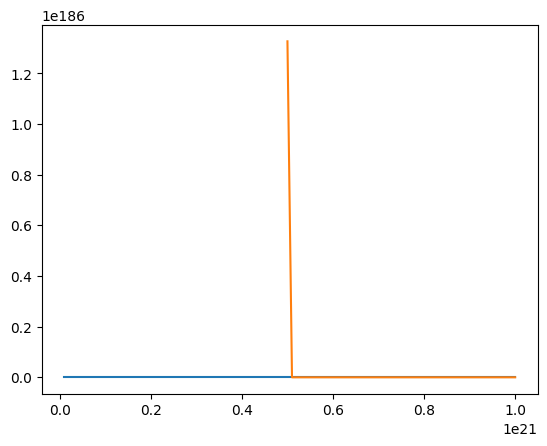

In [227]:
# Плотность
fig, ax = plt.subplots()
draw_time_zero = 1
draw_time_step = 50
for i in range(draw_time_zero, rho.shape[0]-1, draw_time_step):
    ax.plot(r[:], rho[i, :])
plt.show()

In [228]:
rho[-2,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

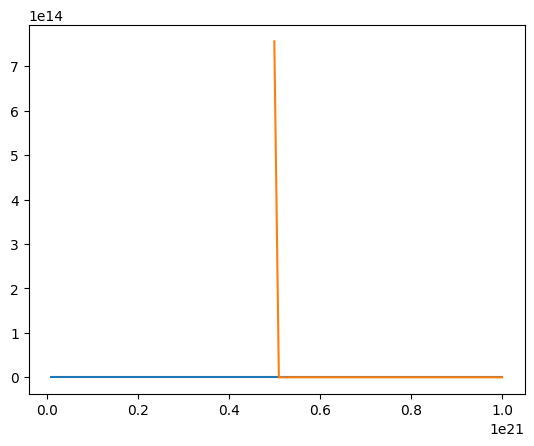

In [229]:
# Скорость
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, U.shape[0]-2, draw_time_step):
    ax.plot(r[:], U[i+1, :])
plt.show()

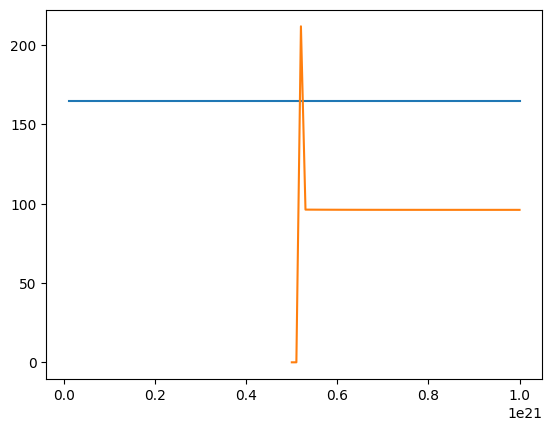

In [230]:
# Температура
fig, ax = plt.subplots()
draw_time_zero = 1
draw_time_step = 50
for i in range(draw_time_zero, T.shape[0]-1, draw_time_step):
    ax.plot(r[:], T[i, :])
plt.show()

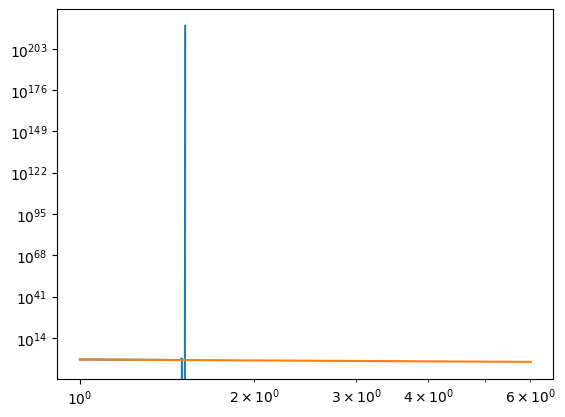

In [231]:
# Проверка плотности
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], rho[:-1, 50]/rho[0, 50])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-2)

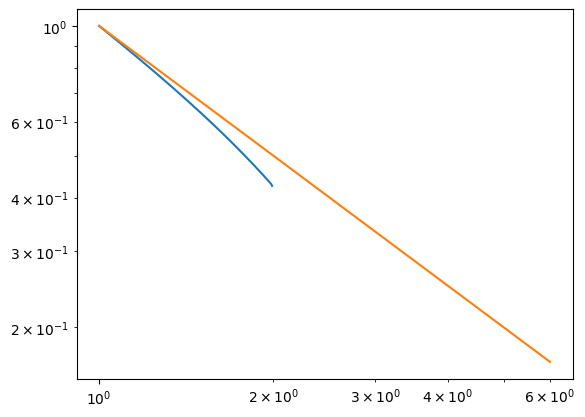

In [232]:
# Проверка скорости
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], U[:-1, -1]/U[0,-1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],H*r[-1]/U[0,-1])

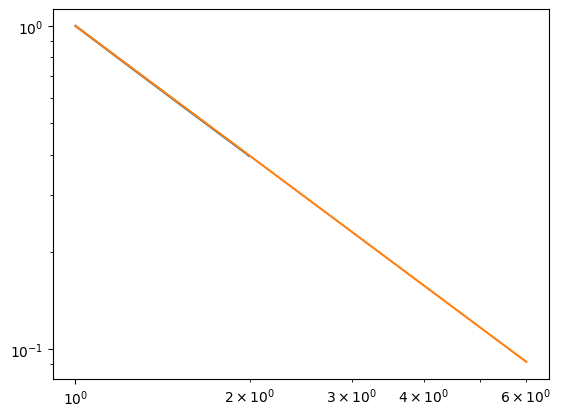

In [233]:
# Проверка температуры
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], T[:-1, -1]/T[0,-1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-(4/3))